In [71]:
import os
import tarfile
import urllib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from zlib import crc32
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from pandas.plotting import scatter_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import joblib

In [2]:
DOWNLOAD_ROOT = 'https://raw.githubusercontent.com/ageron/handson-ml2/master/'
HOUSING_PATH = os.path.join('datasets', 'housing')
HOUSING_URL = DOWNLOAD_ROOT + 'datasets/housing/housing.tgz'

In [3]:
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.exists(housing_path):
        os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, 'housing.tgz')
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, 'housing.csv')
    return pd.read_csv(csv_path)

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
        
    def fit(self, X, y= None):
        return self # nothing else to do
    
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
        

In [4]:
fetch_housing_data()

In [5]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [6]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [7]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


''

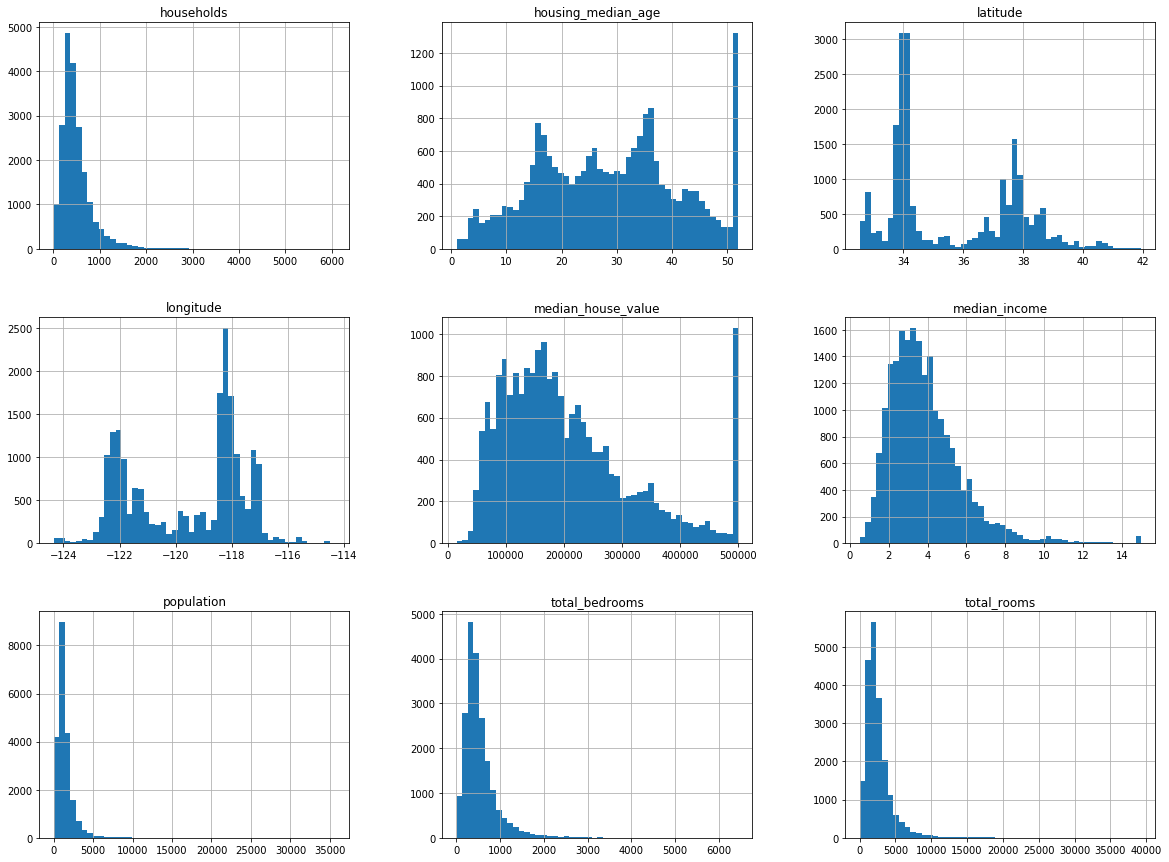

In [8]:
housing.hist(bins=50, figsize=(20,15))
;

In [9]:
# APPROACH 1
# this is used as a first interaction but is not useful at agregating new data since it will break with the new data set
# I just run it for future reference
train_set, test_set = split_train_test(housing, 0.2)

# APPROACH 2
# another approach based on the index column of the data.  This is also NOT recommended if the new data is NOT appended
# at the end of the original dataset
# I just run it for future reference
housing_with_id = housing.reset_index()
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, 'index')

# APPROACH 3
# this is a better MANUAL approach that creates unique identifiers out of the data.
# I just run it for future reference
housing_with_id = housing.copy()
housing_with_id['id'] = housing_with_id['longitude'] * 1000 + housing_with_id['latitude']
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, 'id')

# APPROACH 4
# nonetheless, all of this can achieved directly with sklearn
train_set, test_set = train_test_split(housing, test_size= 0.2, random_state= 42)


In [10]:
print('train set:',len(train_set))
print('test set:',len(test_set))

train set: 16512
test set: 4128


### Splitting stratified data

In [11]:
# this approach should be used on data that is stratified

''

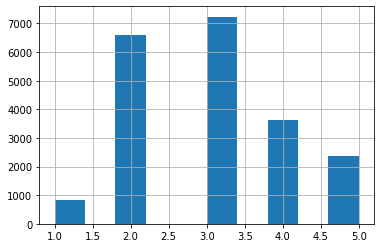

In [12]:
housing['income_cat'] = pd.cut(housing['median_income'],
                               bins= [0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels= [1, 2, 3, 4, 5])

housing['income_cat'].hist()
;

In [13]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set= housing.loc[train_index]
    strat_test_set= housing.loc[test_index]

In [14]:
strat_test_set['income_cat'].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [15]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat', axis= 1, inplace= True)

In [16]:
housing = strat_train_set.copy()

''

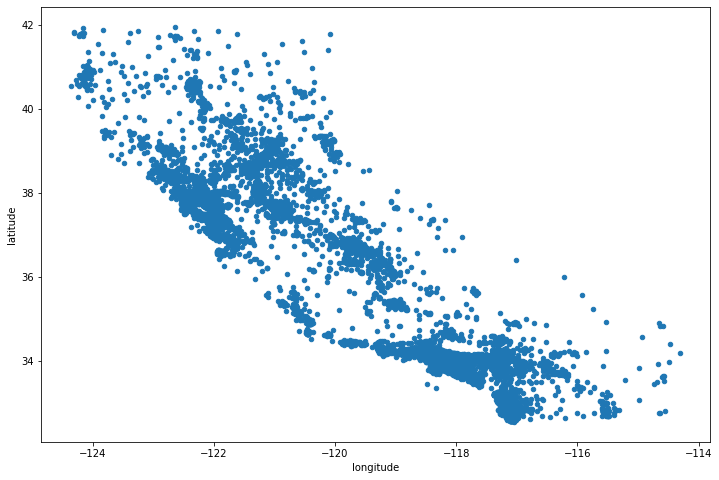

In [17]:
housing.plot(kind= 'scatter', x= 'longitude', y= 'latitude', figsize= (12,8))
;

''

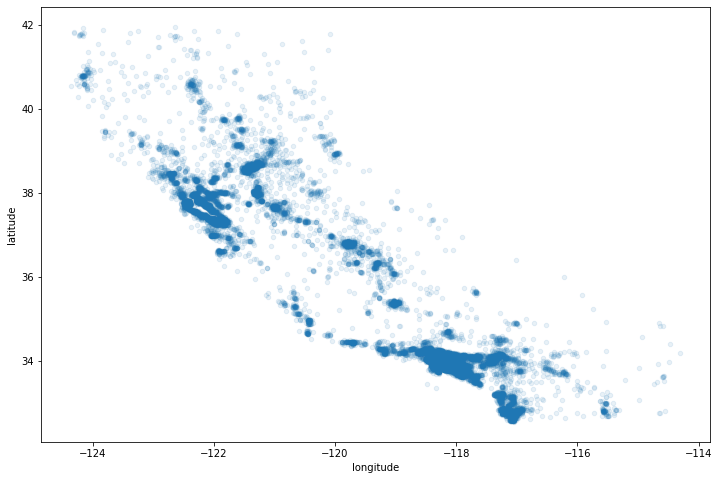

In [18]:
housing.plot(kind= 'scatter', x= 'longitude', y= 'latitude', alpha= 0.1, figsize= (12,8))
;

''

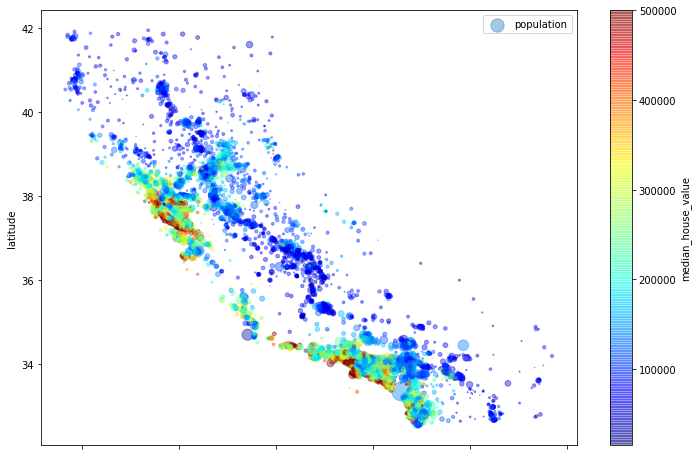

In [19]:
housing.plot(kind= 'scatter', x= 'longitude', y= 'latitude', alpha= 0.4, 
             s= housing['population']/100, label= 'population', figsize= (12,8),
             c= 'median_house_value', cmap= plt.get_cmap('jet'), colorbar= True,)

plt.legend()
; 

In [20]:
corr_matrix = housing.corr()

In [21]:
corr_matrix['median_house_value'].sort_values(ascending= False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

''

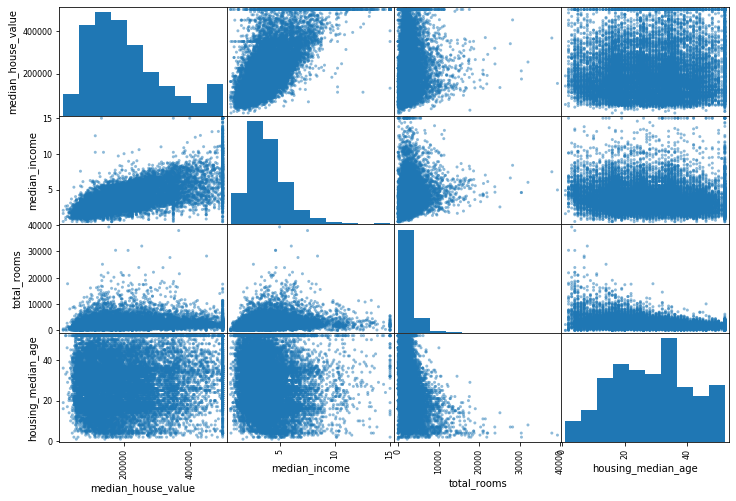

In [22]:
attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']

scatter_matrix(housing[attributes], figsize= (12,8), diagonal= 'hist')
;

''

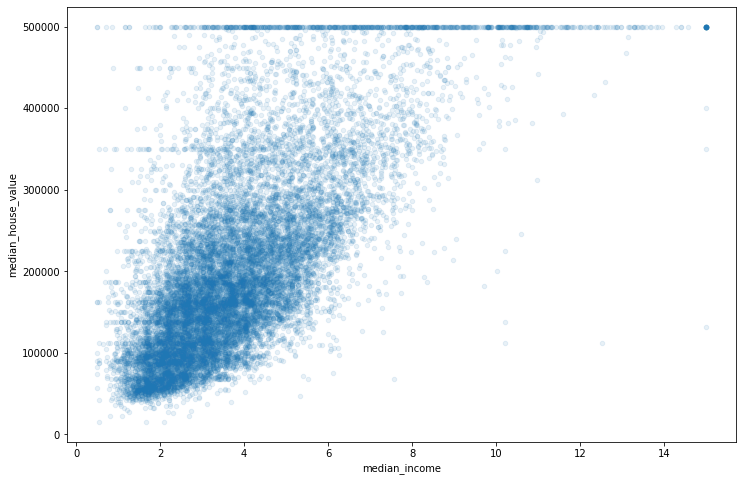

In [23]:
housing.plot(kind= 'scatter', x= 'median_income', y= 'median_house_value', alpha= 0.1, figsize= (12,8))
;

### Experimenting with attribute combinations

In [24]:
housing['rooms_per_household'] = housing['total_rooms'] / housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms'] / housing['total_rooms']
housing['population_per_household'] = housing['population'] / housing['households']

In [25]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending= False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

### Prepare for machine learning and data cleaning

In [26]:
# let's brng the stratified data as our features
housing = strat_train_set.drop('median_house_value', axis= 1)
housing_labels = strat_train_set['median_house_value'].copy()

In [27]:
# fill the missing values in the dataframe
imputer = SimpleImputer(strategy= 'median')

In [28]:
housing_num = housing.drop('ocean_proximity', axis= 1)

In [29]:
imputer.fit(housing_num)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

In [30]:
X = imputer.transform(housing_num)

In [31]:
housing_tr = pd.DataFrame(X, columns= housing_num.columns, index= housing_num.index)

### Handling text and categorical attributes

In [32]:
housing_cat = housing[['ocean_proximity']]
housing_cat.head(10)

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
19480,INLAND
8879,<1H OCEAN
13685,INLAND
4937,<1H OCEAN
4861,<1H OCEAN


In [33]:
housing_cat['ocean_proximity'].value_counts()

<1H OCEAN     7276
INLAND        5263
NEAR OCEAN    2124
NEAR BAY      1847
ISLAND           2
Name: ocean_proximity, dtype: int64

In [34]:
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

In [35]:
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [36]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [37]:
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

In [38]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [39]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

### Custom transformers

In [40]:
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6


attr_adder = CombinedAttributesAdder(add_bedrooms_per_room= False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [41]:
housing_extra_attribs

array([[-121.89, 37.29, 38.0, ..., '<1H OCEAN', 4.625368731563422,
        2.094395280235988],
       [-121.93, 37.05, 14.0, ..., '<1H OCEAN', 6.008849557522124,
        2.7079646017699117],
       [-117.2, 32.77, 31.0, ..., 'NEAR OCEAN', 4.225108225108225,
        2.0259740259740258],
       ...,
       [-116.4, 34.09, 9.0, ..., 'INLAND', 6.34640522875817,
        2.742483660130719],
       [-118.01, 33.82, 31.0, ..., '<1H OCEAN', 5.50561797752809,
        3.808988764044944],
       [-122.45, 37.77, 52.0, ..., 'NEAR BAY', 4.843505477308295,
        1.9859154929577465]], dtype=object)

### Transformation pipelines

In [42]:
num_pipeline = Pipeline([('imputer', SimpleImputer(strategy= 'median')),
                         ('attribs_adder', CombinedAttributesAdder()),
                         ('std_scaler', StandardScaler()),
                        ])

In [43]:
num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

In [44]:
full_pipeline = ColumnTransformer([('num', num_pipeline, num_attribs),
                                   ('cat', OneHotEncoder(), cat_attribs,
                                   )])

In [45]:
housing_prepared = full_pipeline.fit_transform(housing)

### Training and evaluating on the training set

In [46]:
# LINEAR REGRESSION
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [47]:
# let's try out on a few instances from the trainng set
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print('Predictions: ', lin_reg.predict(some_data_prepared))
print('Labels: ', list(some_labels))

Predictions:  [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]
Labels:  [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [48]:
some_data_prepared

array([[-1.15604281,  0.77194962,  0.74333089, -0.49323393, -0.44543821,
        -0.63621141, -0.42069842, -0.61493744, -0.31205452, -0.08649871,
         0.15531753,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , -0.90896655, -1.0369278 ,
        -0.99833135, -1.02222705,  1.33645936,  0.21768338, -0.03353391,
        -0.83628902,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, -0.31365989, -0.15334458,
        -0.43363936, -0.0933178 , -0.5320456 , -0.46531516, -0.09240499,
         0.4222004 ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ],
       [-0.01706767,  0.31357576, -0.29052016, -0.36276217, -0.39675594,
         0.03604096, -0.38343559, -1.04556555, -0.07966124,  0.08973561,
        -0.19645314,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.49247384, -0.65929936, -0

In [49]:
# let's measure this regression model's RMSE on the whole training set using mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848923

In [50]:
lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

49439.89599001897

In [51]:
# DECISION TREE
tree_reg = DecisionTreeRegressor(random_state = 42, ccp_alpha=0.0)
tree_reg.fit(housing_prepared, housing_labels)


DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [52]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [66]:
# RANDOM FOREST
forest_reg = RandomForestRegressor(n_estimators= 100, random_state= 42) #n_estimators= 10, random_state= 42
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [67]:
housing_predictions_tree = forest_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions_tree)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

18603.515021376355

### Better evaluation using cross-validation

In [55]:
# you will find scoring= 'neg_mean_squared_error', but this produces weird numbers in version 0.22.1
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                        scoring= 'neg_root_mean_squared_error', cv= 10)

tree_rmse_scores = np.sqrt(-scores)

In [56]:
def display_scores(scores):
    print('Scores: ', scores)
    print('Mean: ', scores.mean())
    print('Standard deviation: ', scores.std())
    
display_scores(-scores)

Scores:  [70194.33680785 66855.16363941 72432.58244769 70758.73896782
 71115.88230639 75585.14172901 70262.86139133 70273.6325285
 75366.87952553 71231.65726027]
Mean:  71407.68766037929
Standard deviation:  2439.4345041191004


In [57]:
# you will find scoring= 'neg_mean_squared_error', but this produces weird numbers in version 0.22.1
scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                        scoring= 'neg_root_mean_squared_error', cv= 10)

tree_rmse_scores = np.sqrt(-scores)

In [58]:
display_scores(-scores)

Scores:  [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean:  69052.46136345083
Standard deviation:  2731.674001798349


In [68]:
scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                        scoring= 'neg_root_mean_squared_error', cv= 10)

tree_rmse_scores = np.sqrt(-scores)

In [69]:
display_scores(-scores)

Scores:  [49519.80364233 47461.9115823  50029.02762854 52325.28068953
 49308.39426421 53446.37892622 48634.8036574  47585.73832311
 53490.10699751 50021.5852922 ]
Mean:  50182.303100336096
Standard deviation:  2097.0810550985693
